In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=a9bc84011596243555d81434a42371b39befc69303e8e4c080f42e2b1ec4f988
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=378554a2062a04fa42adc1e9ad3691642fbe123be0bb087370e1dd10b91a4a44
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
import numpy as np
from tqdm.notebook import tqdm
import scipy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
import os
from torchmetrics import JaccardIndex
from torchmetrics.detection import IntersectionOverUnion
from segmentation_models_pytorch.losses import DiceLoss
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import os.path as osp


import wandb

!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Preprocessin of OCT Data

In [4]:
import os
import os.path as osp

def get_matching_files(data_dir, phase):
    # List all image and mask files
    img_dir = osp.join(data_dir, phase, 'img')
    mask_dir = osp.join(data_dir, phase, 'mask')

    # Get list of all files in the img and mask directories
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Initialize lists to store matched image-mask pairs
    image_list = []
    mask_list = []

    # Iterate through image files and find corresponding mask
    for img_file in img_files:
        # Base name without extension
        base_name = img_file.split('.')[0]

        # Try to find a matching mask with the same base name
        matching_mask = next((m for m in mask_files if m.startswith(base_name)), None)

        if matching_mask:
            # Add the full path for both image and mask
            image_list.append(osp.join(img_dir, img_file))
            mask_list.append(osp.join(mask_dir, matching_mask))
        else:
            print(f"Warning: No matching mask found for image {img_file}")

    return image_list, mask_list


In [5]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, phase, transforms):
        self.data_dir = data_dir
        self.phase = phase
        self.transforms = transforms
        self.image_list = None
        self.label_list = None
        self.read_lists()

    def __getitem__(self, index):
        image_path = self.image_list[index]
        mask_path = self.label_list[index]

        # Debugging: Ensure the pairing is correct
        # print(f"Image: {image_path}, Mask: {mask_path}")

        image = Image.open(image_path).convert("RGB")
        label = Image.open(mask_path)

        # Apply transformations
        data = list(self.transforms(image, label))
        image = data[0]
        label = data[1]

        return image, label.long()

    def __len__(self):
        return len(self.image_list)

    def read_lists(self):
        # Get matching image and mask files
        self.image_list, self.label_list = get_matching_files(self.data_dir, self.phase)
        print(f"Total number of {self.phase} images: {len(self.image_list)}")


In [6]:
import numpy as np
import torch
from PIL import Image

class Label_Transform(object):
    def __init__(self, label_pixel=(26, 51, 77, 102, 128, 153, 179, 204, 230, 255)):
        self.label_pixel = label_pixel

    def __call__(self, image, label, *args):
        label = np.array(label)
        for i in range(len(self.label_pixel)):
            label[label == self.label_pixel[i]] = i+1

        # Ensure label array is of type uint8 and then convert to tensor
        label = label.astype(np.uint8)
        return image, torch.tensor(label, dtype=torch.long)


class Normalize(object):
    """Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    """

    def __init__(self, mean, std):
        self.mean = torch.FloatTensor(mean)
        self.std = torch.FloatTensor(std)

    def __call__(self, image, label=None):
        for t, m, s in zip(image, self.mean, self.std):
            t.sub_(m).div_(s)
        if label is None:
            return image,
        else:
            return image, label

class ToTensor(object):
    """Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, pic, label=None):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic)
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            nchannel = len(pic.mode)
            img = img.view(pic.size[1], pic.size[0], nchannel)
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        img = img.float().div(255)
        if label is None:
            return img,
        else:
            return img, label

class Resize(object):
    def __init__(self, size):
        self.size = size  # Tuple (width, height) for the new size

    def __call__(self, image, label=None):
        image = image.resize(self.size, Image.BILINEAR)  # Resize image using bilinear interpolation
        if label is not None:
            label = label.resize(self.size, Image.NEAREST)  # Resize mask using nearest-neighbor to preserve labels
        if label is None:
            return image,
        else:
            return image, label



class Compose(object):
    """Composes several transforms together.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, *args):
        for t in self.transforms:
            args = t(*args)
        return args


In [7]:
from torch.utils.data import Subset
transforms = Compose([
    Resize((512, 512)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Label_Transform(),

])


train_dataset = OCTDataset(data_dir = 'drive/My Drive/oct_dataset', phase = 'train',transforms = transforms)
val_dataset = OCTDataset(data_dir = 'drive/My Drive/oct_dataset', phase = 'eval', transforms = transforms)
test_dataset = OCTDataset(data_dir = 'drive/My Drive/oct_dataset', phase = 'test', transforms = transforms)

#Choosing different sizes of dataset
train_size = len(train_dataset)


indices = list(range(train_size))
np.random.seed(42)  # Ensure reproducibility
# np.random.shuffle(indices)
split = int(np.floor(0.1 * train_size))  # Here is where to change number of data
train_indices = indices[:split]

# Use Subset to create a dataset with only the selected indices
train_dataset = Subset(train_dataset, train_indices)

print(len(train_dataset))


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#Example to see what the data shape is
for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break



Total number of train images: 148
Total number of eval images: 48
Total number of test images: 48
14


<ipython-input-6-52f76de3051b>:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


torch.Size([14, 3, 512, 512])
torch.Size([14, 512, 512])


Sample image shape: torch.Size([3, 512, 512])
Sample mask shape: torch.Size([512, 512])


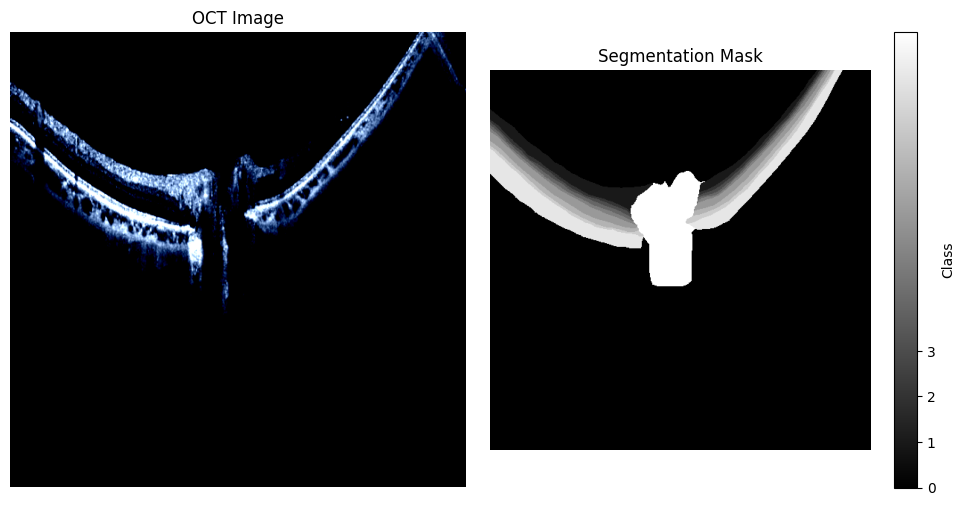

In [8]:
sample_image, sample_mask = train_dataset[10]
print(f"Sample image shape: {sample_image.shape}")
print(f"Sample mask shape: {sample_mask.shape}")

# Visualize a sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.permute(1, 2, 0).numpy(), cmap='gray')
plt.title("OCT Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask.numpy().squeeze(), cmap= 'gray')
plt.title("Segmentation Mask")
plt.colorbar(ticks=range(4), label='Class')
plt.axis('off')

plt.tight_layout()
plt.show()

## ResNet Unet Model with SimCLR No Crop Self-Supervised Learning

In [9]:
# import torch
# import segmentation_models_pytorch as smp

# def load_custom_weights_unet(model, custom_weights_path):
#     # Load the custom weights
#     custom_weights = torch.load(custom_weights_path)

#     if 'model' in custom_weights:
#         custom_weights = custom_weights['model']
#     # **Otherwise, assume the weights are directly in the loaded dictionary:**
#     else:
#         print("Warning: 'model' key not found in weights. Assuming weights are directly in the loaded dictionary.")

#     # Get the state dict of the encoder
#     encoder_state_dict = model.encoder.state_dict()

#     # Create a new state dict for the mapped weights
#     new_state_dict = {}

#     # Define a mapping between custom weight keys and encoder keys
#     key_mapping = {
#         '0': 'firstconv',
#         '1': 'firstbn',
#         '4.0': 'layer1.0',
#         '4.1': 'layer1.1',
#         '4.2': 'layer1.2',
#         '5.0': 'layer2.0',
#         '5.1': 'layer2.1',
#         '5.2': 'layer2.2',
#         '5.3': 'layer2.3',
#         '6.0': 'layer3.0',
#         '6.1': 'layer3.1',
#         '6.2': 'layer3.2',
#         '6.3': 'layer3.3',
#         '6.4': 'layer3.4',
#         '6.5': 'layer3.5',
#         '7.0': 'layer4.0',
#         '7.1': 'layer4.1',
#         '7.2': 'layer4.2',
#     }

#     # Map the custom weights to the encoder structure
#     for k, v in custom_weights.items():
#         for custom_key, encoder_key in key_mapping.items():
#             if k.startswith(custom_key):
#                 new_key = k.replace(custom_key, encoder_key, 1)
#                 if new_key in encoder_state_dict:
#                     new_state_dict[new_key] = v

#     # Load the mapped weights into the encoder
#     model.encoder.load_state_dict(new_state_dict, strict=False)

#     return model

# # Create a U-Net model with a ResNet50 encoder
# model = smp.Unet(
#     encoder_name="resnet50",
#     encoder_weights=None,  # We'll load custom weights
#     in_channels=3,
#     classes=11
# )

# # Load custom pretrained weights for the ResNet50 encoder
# custom_weights_path = 'drive/My Drive/Colab Notebooks/SimCLR/No-Crop/best.pth'
# model = load_custom_weights_unet(model, custom_weights_path)

# # Optionally move the model to GPU if needed
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# print("Custom weights loaded successfully!")

## ResNet Unet Model with Random/ImageNet weights

In [10]:

import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn


# Model
class ResNetUNet(nn.Module):
    def __init__(self, classes):
        super(ResNetUNet, self).__init__()
        self.classes = classes  # Store the number of classes
        self.model = smp.Unet(
            encoder_name="resnet50",
            encoder_weights= None,
            in_channels = 3,
            classes=self.classes,  # Set the number of classes
            activation=None
        )

    def forward(self, x):
        return self.model(x)

model = ResNetUNet(classes = 11)

## Loss Functions

In [11]:
from torchmetrics.classification import Dice, JaccardIndex
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, activation='softmax'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        if self.activation == 'softmax':
            y_pr = F.softmax(y_pr, dim=1)
        elif self.activation == 'sigmoid':
            y_pr = torch.sigmoid(y_pr)

        num_classes = y_pr.shape[1]
        y_gt = F.one_hot(y_gt, num_classes=num_classes).permute(0, 3, 1, 2).float()

        intersection = torch.sum(y_pr * y_gt, dim=[0, 2, 3])
        union = torch.sum(y_pr, dim=[0, 2, 3]) + torch.sum(y_gt, dim=[0, 2, 3])

        dice = (2.0 * intersection + self.eps) / (union + self.eps)
        dice_loss = 1.0 - torch.mean(dice)

        return dice_loss


class CEDiceLoss(nn.Module):
    def __init__(self, eps=1e-7, activation='softmax', lambda_dice=1.0, lambda_ce=1.0):
        super().__init__()
        self.dice_loss = DiceLoss(eps, activation)
        self.ce_loss = nn.CrossEntropyLoss(reduction='mean')
        self.lambda_dice = lambda_dice
        self.lambda_ce = lambda_ce

    def forward(self, y_pr, y_gt):
        dice = self.dice_loss(y_pr, y_gt)
        ce = self.ce_loss(y_pr, y_gt)
        return self.lambda_dice * dice + self.lambda_ce * ce

# Metrics
dice_coef = Dice(average='micro')
iou = JaccardIndex(task="multiclass", num_classes=11)

## Training and Validation

In [12]:
# Initialize W&B
wandb.init(
    project="Final_Research",
    config={
        "learning_rate": 1e-3,
        "data size" : 14
        },
    name="U-Net Random 10"
    )

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 2455744 (2455744-university-of-witwatersrand). Use `wandb login --relogin` to force relogin


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchmetrics import Accuracy


def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device):


    best_val_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    patience = 20 # Early stopping patience
    patience_counter = 0

    # Initialize metrics
    dice_metric = Dice(average='micro').to(device)
    iou_metric = JaccardIndex(task="multiclass", num_classes=11).to(device)
    accuracy_metric = Accuracy(task="multiclass", num_classes=11).to(device)

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_acc = 0.0

        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            data, target = data.float().to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            with torch.no_grad():
                pred_labels = torch.argmax(output, dim=1)
                train_dice += dice_metric(pred_labels, target)
                train_iou += iou_metric(pred_labels, target)
                train_acc += accuracy_metric(pred_labels, target)
        #Averages
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        train_acc /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_acc =0.0
        with torch.no_grad():
            for data, target, *_ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                data, target = data.float().to(device), target.to(device)
                output = model(data)

                loss = loss_fn(output, target)
                val_loss += loss.item()

                pred_labels = torch.argmax(output, dim=1)
                val_dice += dice_metric(pred_labels, target)
                val_iou += iou_metric(pred_labels, target)
                val_acc += accuracy_metric(pred_labels, target)

        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        val_acc /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'drive/MyDrive/Colab Notebooks/Unet Random/Best_model_10.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

        # Log metrics to W&B
        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss,
            "Train Dice": train_dice,
            "Train IoU": train_iou,
            "Train Accuracy": train_acc,
            "Val Loss": val_loss,
            "Val Dice": val_dice,
            "Val IoU": val_iou,
            "Val Accuracy": val_acc,
            "Learning Rate": optimizer.param_groups[0]['lr']
        })

    # wandb.finish()
    return model

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_results(model, data_loader, device, num_samples=5, class_colors=None):
    model.eval()
    images, targets, predictions = [], [], []

    with torch.no_grad():
        for data, target, *_ in data_loader:
            if len(images) >= num_samples:
                break
            data, target = data.float().to(device), target.long().to(device)
            output = model(data)
            pred = torch.argmax(output, dim=1)

            images.extend(data.cpu())
            targets.extend(target.cpu())
            predictions.extend(pred.cpu())

    images = images[:num_samples]
    targets = targets[:num_samples]
    predictions = predictions[:num_samples]

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        # Original Image
        img = images[i].permute(1, 2, 0).numpy()
        if img.min() < 0 or img.max() > 1:  # Check if image needs normalization adjustment
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        # Ground Truth
        gt_mask = targets[i].squeeze().numpy()
        if class_colors:
            gt_colored = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3), dtype=np.uint8)
            for class_idx, color in enumerate(class_colors):
                gt_colored[gt_mask == class_idx] = color
            axs[i, 1].imshow(gt_colored)
        else:
            axs[i, 1].imshow(gt_mask, cmap='gray')  # Use grayscale if no colors provided
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')

        # Prediction
        pred_mask = predictions[i].squeeze().numpy()
        if class_colors:
            pred_colored = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
            for class_idx, color in enumerate(class_colors):
                pred_colored[pred_mask == class_idx] = color
            axs[i, 2].imshow(pred_colored)
        else:
            axs[i, 2].imshow(pred_mask, cmap='gray')  # Use grayscale if no colors provided
        axs[i, 2].set_title('Prediction')
        axs[i, 2].axis('off')

    plt.tight_layout()
    return fig


In [15]:
# Define your model, loss function, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = CEDiceLoss(lambda_dice=0, lambda_ce=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
trained_model = train(model, train_loader, val_loader, epochs=100, loss_fn=loss_fn, optimizer=optimizer, device=device)

# Define class colors (adjust according to your classes)
class_colors = [
    [0, 0, 0],        # Class 0 (black)
    [255, 0, 0],      # Class 1 (red)
    [0, 255, 0],      # Class 2 (green)
    [0, 0, 255],      # Class 3 (blue)
    [255, 255, 0],    # Class 4 (yellow)
    [255, 0, 255],    # Class 5 (magenta)
    [0, 255, 255],    # Class 6 (cyan)
    [192, 192, 192],  # Class 7 (silver)
    [128, 0, 0],      # Class 8 (maroon)
    [128, 128, 0],    # Class 9 (olive)
    [0, 128, 0]       # Class 10 (dark green)
]

# # Visualize results after training
# fig = visualize_results(trained_model, val_loader, device, num_samples=5, class_colors=class_colors)
# plt.show()

# # Log the visualization to W&B
# wandb.init(project="Final_Research", name="Post_Training_Visualisation_U-Net_random_10 ")
# wandb.log({"Validation Predictions U-Net random 10 ": wandb.Image(fig)})


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100 - Validation: 100%|██████████| 3/3 [01:13<00:00, 24.34s/it]


Epoch 1: Train Loss: 2.1499, Train Dice: 0.3045, Train IoU: 0.0412, Val Loss: 3.6280, Val Dice: 0.0709, Val IoU: 0.0078


Epoch 2/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 2: Train Loss: 1.7926, Train Dice: 0.6027, Train IoU: 0.0851, Val Loss: 2.3237, Val Dice: 0.3885, Val IoU: 0.0545


Epoch 3/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 3: Train Loss: 1.5812, Train Dice: 0.6947, Train IoU: 0.0967, Val Loss: 2.1573, Val Dice: 0.8436, Val IoU: 0.1010


Epoch 4/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 4: Train Loss: 1.3830, Train Dice: 0.7186, Train IoU: 0.1063, Val Loss: 1.8840, Val Dice: 0.8608, Val IoU: 0.0980


Epoch 5/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch 5: Train Loss: 1.2457, Train Dice: 0.7677, Train IoU: 0.1232, Val Loss: 1.6788, Val Dice: 0.8645, Val IoU: 0.1000


Epoch 6/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 6: Train Loss: 1.1410, Train Dice: 0.7972, Train IoU: 0.1305, Val Loss: 1.4936, Val Dice: 0.8687, Val IoU: 0.1039


Epoch 7/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 7: Train Loss: 1.0531, Train Dice: 0.8203, Train IoU: 0.1384, Val Loss: 1.3387, Val Dice: 0.8719, Val IoU: 0.1056


Epoch 8/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 8: Train Loss: 0.9740, Train Dice: 0.8398, Train IoU: 0.1468, Val Loss: 1.2337, Val Dice: 0.8738, Val IoU: 0.1049


Epoch 9/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 9: Train Loss: 0.8997, Train Dice: 0.8558, Train IoU: 0.1556, Val Loss: 1.1466, Val Dice: 0.8746, Val IoU: 0.1026


Epoch 10/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 10: Train Loss: 0.8357, Train Dice: 0.8674, Train IoU: 0.1666, Val Loss: 1.0851, Val Dice: 0.8745, Val IoU: 0.0997


Epoch 11/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 11: Train Loss: 0.7802, Train Dice: 0.8743, Train IoU: 0.1786, Val Loss: 1.0150, Val Dice: 0.8747, Val IoU: 0.0992


Epoch 12/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 12: Train Loss: 0.7305, Train Dice: 0.8791, Train IoU: 0.1905, Val Loss: 0.9463, Val Dice: 0.8754, Val IoU: 0.1013


Epoch 13/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch 13: Train Loss: 0.6846, Train Dice: 0.8829, Train IoU: 0.2007, Val Loss: 0.8558, Val Dice: 0.8761, Val IoU: 0.1043


Epoch 14/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 14: Train Loss: 0.6421, Train Dice: 0.8864, Train IoU: 0.2092, Val Loss: 0.8000, Val Dice: 0.8769, Val IoU: 0.1076


Epoch 15/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 15: Train Loss: 0.6035, Train Dice: 0.8902, Train IoU: 0.2167, Val Loss: 0.7699, Val Dice: 0.8777, Val IoU: 0.1110


Epoch 16/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 16: Train Loss: 0.5691, Train Dice: 0.8937, Train IoU: 0.2217, Val Loss: 0.7352, Val Dice: 0.8784, Val IoU: 0.1146


Epoch 17/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 17: Train Loss: 0.5383, Train Dice: 0.8969, Train IoU: 0.2258, Val Loss: 0.6919, Val Dice: 0.8789, Val IoU: 0.1172


Epoch 18/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 18: Train Loss: 0.5099, Train Dice: 0.9003, Train IoU: 0.2307, Val Loss: 0.6582, Val Dice: 0.8791, Val IoU: 0.1190


Epoch 19/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 19: Train Loss: 0.4838, Train Dice: 0.9035, Train IoU: 0.2359, Val Loss: 0.6385, Val Dice: 0.8793, Val IoU: 0.1208


Epoch 20/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 20: Train Loss: 0.4595, Train Dice: 0.9055, Train IoU: 0.2376, Val Loss: 0.6319, Val Dice: 0.8800, Val IoU: 0.1240


Epoch 21/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Epoch 21: Train Loss: 0.4369, Train Dice: 0.9066, Train IoU: 0.2369, Val Loss: 0.6232, Val Dice: 0.8805, Val IoU: 0.1270


Epoch 22/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 22: Train Loss: 0.4164, Train Dice: 0.9076, Train IoU: 0.2362, Val Loss: 0.6137, Val Dice: 0.8805, Val IoU: 0.1283


Epoch 23/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 23: Train Loss: 0.3974, Train Dice: 0.9081, Train IoU: 0.2358, Val Loss: 0.6065, Val Dice: 0.8800, Val IoU: 0.1281


Epoch 24/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 24: Train Loss: 0.3800, Train Dice: 0.9085, Train IoU: 0.2360, Val Loss: 0.5821, Val Dice: 0.8813, Val IoU: 0.1326


Epoch 25/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 25: Train Loss: 0.3644, Train Dice: 0.9091, Train IoU: 0.2377, Val Loss: 0.5619, Val Dice: 0.8820, Val IoU: 0.1351


Epoch 26/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 26: Train Loss: 0.3505, Train Dice: 0.9108, Train IoU: 0.2411, Val Loss: 0.5334, Val Dice: 0.8820, Val IoU: 0.1348


Epoch 27/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 27: Train Loss: 0.3370, Train Dice: 0.9124, Train IoU: 0.2446, Val Loss: 0.5272, Val Dice: 0.8803, Val IoU: 0.1311


Epoch 28/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 28: Train Loss: 0.3257, Train Dice: 0.9149, Train IoU: 0.2480, Val Loss: 0.4543, Val Dice: 0.8912, Val IoU: 0.1661


Epoch 29/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 29: Train Loss: 0.3159, Train Dice: 0.9144, Train IoU: 0.2516, Val Loss: 0.4744, Val Dice: 0.8874, Val IoU: 0.1592


Epoch 30/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 30: Train Loss: 0.3121, Train Dice: 0.9167, Train IoU: 0.2565, Val Loss: 0.3966, Val Dice: 0.9019, Val IoU: 0.1912


Epoch 31/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 31: Train Loss: 0.2995, Train Dice: 0.9164, Train IoU: 0.2623, Val Loss: 0.3654, Val Dice: 0.9076, Val IoU: 0.2059


Epoch 32/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 32: Train Loss: 0.2881, Train Dice: 0.9205, Train IoU: 0.2713, Val Loss: 0.3697, Val Dice: 0.9059, Val IoU: 0.2025


Epoch 33/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 33: Train Loss: 0.2821, Train Dice: 0.9224, Train IoU: 0.2735, Val Loss: 0.3571, Val Dice: 0.9079, Val IoU: 0.2099


Epoch 34/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 34: Train Loss: 0.2727, Train Dice: 0.9232, Train IoU: 0.2769, Val Loss: 0.3449, Val Dice: 0.9079, Val IoU: 0.2148


Epoch 35/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 35: Train Loss: 0.2688, Train Dice: 0.9217, Train IoU: 0.2778, Val Loss: 0.3491, Val Dice: 0.9072, Val IoU: 0.2109


Epoch 36/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 36: Train Loss: 0.2607, Train Dice: 0.9267, Train IoU: 0.2885, Val Loss: 0.3509, Val Dice: 0.9053, Val IoU: 0.2082


Epoch 37/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 37: Train Loss: 0.2542, Train Dice: 0.9300, Train IoU: 0.3006, Val Loss: 0.3268, Val Dice: 0.9089, Val IoU: 0.2209


Epoch 38/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 38: Train Loss: 0.2496, Train Dice: 0.9310, Train IoU: 0.3069, Val Loss: 0.3170, Val Dice: 0.9123, Val IoU: 0.2297


Epoch 39/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 39: Train Loss: 0.2420, Train Dice: 0.9334, Train IoU: 0.3122, Val Loss: 0.3208, Val Dice: 0.9110, Val IoU: 0.2274


Epoch 40/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 40: Train Loss: 0.2383, Train Dice: 0.9338, Train IoU: 0.3129, Val Loss: 0.3047, Val Dice: 0.9154, Val IoU: 0.2409


Epoch 41/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch 41: Train Loss: 0.2314, Train Dice: 0.9359, Train IoU: 0.3217, Val Loss: 0.2944, Val Dice: 0.9190, Val IoU: 0.2524


Epoch 42/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 42: Train Loss: 0.2273, Train Dice: 0.9368, Train IoU: 0.3261, Val Loss: 0.2995, Val Dice: 0.9182, Val IoU: 0.2481


Epoch 43/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 43: Train Loss: 0.2228, Train Dice: 0.9373, Train IoU: 0.3247, Val Loss: 0.2902, Val Dice: 0.9201, Val IoU: 0.2535


Epoch 44/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 44: Train Loss: 0.2172, Train Dice: 0.9388, Train IoU: 0.3312, Val Loss: 0.2847, Val Dice: 0.9210, Val IoU: 0.2567


Epoch 45/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch 45: Train Loss: 0.2137, Train Dice: 0.9393, Train IoU: 0.3342, Val Loss: 0.2955, Val Dice: 0.9182, Val IoU: 0.2466


Epoch 46/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 46: Train Loss: 0.2094, Train Dice: 0.9397, Train IoU: 0.3320, Val Loss: 0.2841, Val Dice: 0.9199, Val IoU: 0.2527


Epoch 47/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch 47: Train Loss: 0.2052, Train Dice: 0.9406, Train IoU: 0.3400, Val Loss: 0.2836, Val Dice: 0.9201, Val IoU: 0.2534


Epoch 48/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 48: Train Loss: 0.2009, Train Dice: 0.9416, Train IoU: 0.3408, Val Loss: 0.2841, Val Dice: 0.9201, Val IoU: 0.2533


Epoch 49/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 49: Train Loss: 0.1971, Train Dice: 0.9423, Train IoU: 0.3441, Val Loss: 0.2762, Val Dice: 0.9213, Val IoU: 0.2590


Epoch 50/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 50: Train Loss: 0.1940, Train Dice: 0.9430, Train IoU: 0.3524, Val Loss: 0.2774, Val Dice: 0.9217, Val IoU: 0.2580


Epoch 51/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch 51: Train Loss: 0.1904, Train Dice: 0.9433, Train IoU: 0.3494, Val Loss: 0.2700, Val Dice: 0.9229, Val IoU: 0.2656


Epoch 52/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 52: Train Loss: 0.1877, Train Dice: 0.9440, Train IoU: 0.3597, Val Loss: 0.2762, Val Dice: 0.9218, Val IoU: 0.2600


Epoch 53/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 53: Train Loss: 0.1850, Train Dice: 0.9442, Train IoU: 0.3575, Val Loss: 0.2636, Val Dice: 0.9245, Val IoU: 0.2750


Epoch 54/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 54: Train Loss: 0.1819, Train Dice: 0.9452, Train IoU: 0.3715, Val Loss: 0.2685, Val Dice: 0.9243, Val IoU: 0.2724


Epoch 55/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 55: Train Loss: 0.1775, Train Dice: 0.9464, Train IoU: 0.3712, Val Loss: 0.2620, Val Dice: 0.9256, Val IoU: 0.2807


Epoch 56/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 56: Train Loss: 0.1735, Train Dice: 0.9480, Train IoU: 0.3851, Val Loss: 0.2617, Val Dice: 0.9261, Val IoU: 0.2840


Epoch 57/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 57: Train Loss: 0.1708, Train Dice: 0.9487, Train IoU: 0.3925, Val Loss: 0.2693, Val Dice: 0.9254, Val IoU: 0.2807


Epoch 58/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 58: Train Loss: 0.1685, Train Dice: 0.9493, Train IoU: 0.3946, Val Loss: 0.2631, Val Dice: 0.9254, Val IoU: 0.2883


Epoch 59/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 59: Train Loss: 0.1655, Train Dice: 0.9503, Train IoU: 0.4089, Val Loss: 0.2699, Val Dice: 0.9256, Val IoU: 0.2849


Epoch 60/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 60: Train Loss: 0.1620, Train Dice: 0.9513, Train IoU: 0.4124, Val Loss: 0.2699, Val Dice: 0.9259, Val IoU: 0.2871


Epoch 61/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 61: Train Loss: 0.1592, Train Dice: 0.9524, Train IoU: 0.4223, Val Loss: 0.2680, Val Dice: 0.9258, Val IoU: 0.2899


Epoch 62/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 62: Train Loss: 0.1567, Train Dice: 0.9532, Train IoU: 0.4321, Val Loss: 0.2678, Val Dice: 0.9269, Val IoU: 0.2976


Epoch 63/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 63: Train Loss: 0.1545, Train Dice: 0.9540, Train IoU: 0.4403, Val Loss: 0.2646, Val Dice: 0.9275, Val IoU: 0.3012


Epoch 64/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 64: Train Loss: 0.1534, Train Dice: 0.9546, Train IoU: 0.4419, Val Loss: 0.2623, Val Dice: 0.9278, Val IoU: 0.3035


Epoch 65/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 65: Train Loss: 0.1523, Train Dice: 0.9550, Train IoU: 0.4432, Val Loss: 0.2610, Val Dice: 0.9279, Val IoU: 0.3048


Epoch 66/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 66: Train Loss: 0.1521, Train Dice: 0.9550, Train IoU: 0.4435, Val Loss: 0.2599, Val Dice: 0.9280, Val IoU: 0.3064


Epoch 67/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 67: Train Loss: 0.1523, Train Dice: 0.9548, Train IoU: 0.4437, Val Loss: 0.2583, Val Dice: 0.9283, Val IoU: 0.3090


Epoch 68/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 68: Train Loss: 0.1520, Train Dice: 0.9549, Train IoU: 0.4448, Val Loss: 0.2560, Val Dice: 0.9289, Val IoU: 0.3124


Epoch 69/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 69: Train Loss: 0.1513, Train Dice: 0.9553, Train IoU: 0.4469, Val Loss: 0.2535, Val Dice: 0.9295, Val IoU: 0.3161


Epoch 70/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 70: Train Loss: 0.1507, Train Dice: 0.9557, Train IoU: 0.4487, Val Loss: 0.2514, Val Dice: 0.9300, Val IoU: 0.3195


Epoch 71/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 71: Train Loss: 0.1504, Train Dice: 0.9557, Train IoU: 0.4497, Val Loss: 0.2498, Val Dice: 0.9304, Val IoU: 0.3221


Epoch 72/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 72: Train Loss: 0.1503, Train Dice: 0.9557, Train IoU: 0.4502, Val Loss: 0.2484, Val Dice: 0.9306, Val IoU: 0.3243


Epoch 73/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 73: Train Loss: 0.1499, Train Dice: 0.9559, Train IoU: 0.4512, Val Loss: 0.2470, Val Dice: 0.9308, Val IoU: 0.3261


Epoch 74/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 74: Train Loss: 0.1494, Train Dice: 0.9561, Train IoU: 0.4522, Val Loss: 0.2458, Val Dice: 0.9309, Val IoU: 0.3276


Epoch 75/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 75: Train Loss: 0.1489, Train Dice: 0.9563, Train IoU: 0.4533, Val Loss: 0.2450, Val Dice: 0.9309, Val IoU: 0.3292


Epoch 76/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 76: Train Loss: 0.1487, Train Dice: 0.9563, Train IoU: 0.4543, Val Loss: 0.2445, Val Dice: 0.9310, Val IoU: 0.3308


Epoch 77/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 77: Train Loss: 0.1484, Train Dice: 0.9564, Train IoU: 0.4554, Val Loss: 0.2439, Val Dice: 0.9311, Val IoU: 0.3325


Epoch 78/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Epoch 78: Train Loss: 0.1480, Train Dice: 0.9566, Train IoU: 0.4570, Val Loss: 0.2433, Val Dice: 0.9314, Val IoU: 0.3343


Epoch 79/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 79: Train Loss: 0.1476, Train Dice: 0.9568, Train IoU: 0.4586, Val Loss: 0.2427, Val Dice: 0.9317, Val IoU: 0.3359


Epoch 80/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 80: Train Loss: 0.1473, Train Dice: 0.9570, Train IoU: 0.4598, Val Loss: 0.2424, Val Dice: 0.9320, Val IoU: 0.3371


Epoch 81/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 81: Train Loss: 0.1469, Train Dice: 0.9571, Train IoU: 0.4606, Val Loss: 0.2421, Val Dice: 0.9321, Val IoU: 0.3380


Epoch 82/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 82: Train Loss: 0.1466, Train Dice: 0.9572, Train IoU: 0.4612, Val Loss: 0.2419, Val Dice: 0.9323, Val IoU: 0.3389


Epoch 83/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 83: Train Loss: 0.1463, Train Dice: 0.9573, Train IoU: 0.4621, Val Loss: 0.2416, Val Dice: 0.9323, Val IoU: 0.3397


Epoch 84/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 84: Train Loss: 0.1459, Train Dice: 0.9575, Train IoU: 0.4632, Val Loss: 0.2415, Val Dice: 0.9323, Val IoU: 0.3403


Epoch 85/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 85: Train Loss: 0.1455, Train Dice: 0.9576, Train IoU: 0.4646, Val Loss: 0.2415, Val Dice: 0.9322, Val IoU: 0.3412


Epoch 86/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 86: Train Loss: 0.1452, Train Dice: 0.9577, Train IoU: 0.4660, Val Loss: 0.2415, Val Dice: 0.9322, Val IoU: 0.3422


Epoch 87/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch 87: Train Loss: 0.1449, Train Dice: 0.9579, Train IoU: 0.4674, Val Loss: 0.2414, Val Dice: 0.9324, Val IoU: 0.3432


Epoch 88/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Epoch 88: Train Loss: 0.1446, Train Dice: 0.9581, Train IoU: 0.4688, Val Loss: 0.2411, Val Dice: 0.9326, Val IoU: 0.3443


Epoch 89/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 89: Train Loss: 0.1442, Train Dice: 0.9583, Train IoU: 0.4700, Val Loss: 0.2409, Val Dice: 0.9328, Val IoU: 0.3452


Epoch 90/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Epoch 90: Train Loss: 0.1438, Train Dice: 0.9584, Train IoU: 0.4710, Val Loss: 0.2407, Val Dice: 0.9329, Val IoU: 0.3461


Epoch 91/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 91: Train Loss: 0.1435, Train Dice: 0.9585, Train IoU: 0.4718, Val Loss: 0.2406, Val Dice: 0.9330, Val IoU: 0.3470


Epoch 92/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Epoch 92: Train Loss: 0.1432, Train Dice: 0.9586, Train IoU: 0.4729, Val Loss: 0.2406, Val Dice: 0.9330, Val IoU: 0.3479


Epoch 93/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 93: Train Loss: 0.1428, Train Dice: 0.9588, Train IoU: 0.4744, Val Loss: 0.2406, Val Dice: 0.9330, Val IoU: 0.3487


Epoch 94/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Epoch 94: Train Loss: 0.1425, Train Dice: 0.9589, Train IoU: 0.4758, Val Loss: 0.2407, Val Dice: 0.9330, Val IoU: 0.3495


Epoch 95/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Epoch 95: Train Loss: 0.1422, Train Dice: 0.9591, Train IoU: 0.4771, Val Loss: 0.2407, Val Dice: 0.9331, Val IoU: 0.3503


Epoch 96/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 96: Train Loss: 0.1418, Train Dice: 0.9592, Train IoU: 0.4782, Val Loss: 0.2407, Val Dice: 0.9333, Val IoU: 0.3510


Epoch 97/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 97: Train Loss: 0.1415, Train Dice: 0.9593, Train IoU: 0.4794, Val Loss: 0.2405, Val Dice: 0.9335, Val IoU: 0.3519


Epoch 98/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Epoch 98: Train Loss: 0.1411, Train Dice: 0.9595, Train IoU: 0.4803, Val Loss: 0.2404, Val Dice: 0.9336, Val IoU: 0.3528


Epoch 99/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 99: Train Loss: 0.1408, Train Dice: 0.9596, Train IoU: 0.4816, Val Loss: 0.2403, Val Dice: 0.9337, Val IoU: 0.3538


Epoch 100/100 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 100: Train Loss: 0.1405, Train Dice: 0.9598, Train IoU: 0.4828, Val Loss: 0.2402, Val Dice: 0.9337, Val IoU: 0.3548


In [16]:
from tqdm import tqdm

def test(model, test_loader, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_dice = 0.0
    test_iou = 0.0
    test_acc =0.0

    dice_metric = Dice(average='micro').to(device)
    iou_metric = JaccardIndex(task="multiclass", num_classes=11).to(device)  # Adjust num_classes as needed
    accuracy_metric = Accuracy(task="multiclass", num_classes=11).to(device)
    with torch.no_grad():  # Disable gradient computation
        for data, target, *_ in tqdm(test_loader, desc="Testing"):
            data, target = data.float().to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = loss_fn(output, target)
            test_loss += loss.item()

            # Get predictions
            pred_labels = torch.argmax(output, dim=1)

            # Calculate metrics
            test_dice += dice_metric(pred_labels, target)
            test_iou += iou_metric(pred_labels, target)
            test_acc += accuracy_metric(pred_labels, target)

    # Average metrics over all batches
    test_loss /= len(test_loader)
    test_dice /= len(test_loader)
    test_iou /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")

    return test_loss, test_dice, test_iou, test_acc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/Unet Random/Best_model_10.pth'))
loss_fn = CEDiceLoss(lambda_dice=0, lambda_ce=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run the test function
test_loss, test_dice, test_iou, test_acc = test(model, test_loader, loss_fn, device)

# Optionally, log test results to W&B
wandb.init(project="Final_Research", name="Test_Results_Unet_Random_10")
wandb.log({
    "Test Loss": test_loss,
    "Test Dice": test_dice,
    "Test IoU": test_iou,
    "Test Accuracy": test_acc
})
wandb.finish()

# fig = visualize_results(trained_model, test_loader, device, num_samples=5, class_colors=class_colors)
# plt.show()

# # Log the visualization to W&B
# wandb.init(project="Final_Research", name="Test_Visualization_U_Net_Random_10")
# wandb.log({"Final Predictions: Unet random 10": wandb.Image(fig)})
# wandb.finish()

<ipython-input-16-5727b00ff739>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/Unet Random/Best_model_10.p

Test Loss: 0.2228, Test Dice: 0.9361, Test IoU: 0.3789


Epoch,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
Learning Rate,████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
Train Dice,▁▂▃▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Train IoU,▁▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████████████
Train Loss,█▇▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▇▇▇▇▇▇▇▇▇██████████████████████████████
Val Dice,▁▇▇▇▇▇▇▇▇▇██████████████████████████████
Val IoU,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▄▅▅▆▆▆▆▆▇▇▇▇▇▇████████
Val Loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100


Test Accuracy,▁
Test Dice,▁
Test IoU,▁
Test Loss,▁
Test Accuracy,0.93612
Test Dice,0.93612
Test IoU,0.37892
Test Loss,0.22279
